In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import metrics


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
price_house = pd.read_csv('..\\02_Ouput\\historico_madrid_limpio.csv')

In [4]:
price_house.shape

(76241, 19)

In [5]:
price_house.head()

,Unnamed: 0,Fecha,year,price,postal_code,cod_distrito,year_distrito,size,bedrooms,bathrooms,price_m2,lift,swimming_pool,garden,sports,status,air_conditioning,construction_year,exterior
0,1,2002-11-14,2002,138232.0,28011,10,102002,70.0,2,1,1974.7429,1,0,0,0,2,0,1972,0
1,2,2003-01-22,2003,195349.0,28041,12,122003,84.0,2,2,2325.5833,1,1,1,1,2,0,1999,0
2,3,2003-02-21,2003,140740.0,28030,14,142003,60.0,3,1,2345.6667,1,0,0,0,2,0,1973,0
3,4,2003-03-10,2003,167000.0,28011,10,102003,60.5,2,1,2760.3306,1,0,0,0,2,0,1965,0
4,5,2003-03-10,2003,165000.0,28011,10,102003,77.1,3,1,2140.0778,1,0,0,0,2,0,1980,0


## Incluimos las variables macro estimadas al dataframe

Previamente se ha unificado en un solo archivo todas las variables macro que se han podido obtener y estimar. 
Se trata de la variables:
* Renta de las familias
* Compraventas de inmuebles
* Total inmuebles (parque de viviendas)
* Número de parados
* Población

Todas ellas a nivel distrito.

Importamos dicho archivo para poder unir ambos dataframe. El archivo se encuentra en la carpeta 01_data del repositorio con el nombre de "variables_macro.xlsx"

In [6]:
variables_macro =pd.read_excel("..\\00_Data\\variables_macro.xlsx")

No se han podido obtener datos anteriores a 2013 de todas las variables por lo que vamos a tener en cuenta únicamente los datos desde 2013 de nuestro price_house

In [7]:
price_house = price_house[price_house["Fecha"]>"2013"]

Una vez tenemos el perímetro definido, unimos ambos dataframe (price_house y variables_macro)

In [8]:
price_house_macro = price_house.merge(variables_macro, on='year_distrito', how='right')

Al hacer el join se han añadido dos columnas (Year y distrito) que no aportan nada. Las eliminamos

In [9]:
price_house_macro.drop(['Year','Distrito' ], axis='columns', inplace=True)
price_house_macro.head()

,Unnamed: 0,Fecha,year,price,postal_code,cod_distrito,year_distrito,size,bedrooms,bathrooms,...,sports,status,air_conditioning,construction_year,exterior,Renta,Compraventas,Inmuebles,Parados,Poblacion
0,18759,2013-01-02,2013,405000.0,28009,3,32013,107.0,3,1,...,0,2,0,1920,0,48274.412352,772.0,53690.0,78470.0,120810
1,18993,2013-01-28,2013,200000.0,28014,3,32013,71.0,2,1,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810
2,19002,2013-01-28,2013,205000.0,28014,3,32013,78.0,1,1,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810
3,19007,2013-01-28,2013,200000.0,28014,3,32013,76.0,3,1,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810
4,19011,2013-01-28,2013,250000.0,28014,3,32013,86.0,3,1,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810


## A partir de aquí es igual que el script de Modelo no macro pero con nuevas variables

In [10]:
# Hold-out. Separo los datos de entrenamiento y test por fechas. Es lo más lógico para datos temporales
train = price_house_macro[price_house_macro["Fecha"]<"2018"]
test = price_house_macro[price_house_macro["Fecha"]>="2018"]

In [11]:
#leemos train y eliminamos las columnas que se han creado anteriormente
train.columns.values
train.drop(['Unnamed: 0'], axis='columns', inplace=True)
train.head()

C:\Users\Lor\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Fecha,year,price,postal_code,cod_distrito,year_distrito,size,bedrooms,bathrooms,price_m2,...,sports,status,air_conditioning,construction_year,exterior,Renta,Compraventas,Inmuebles,Parados,Poblacion
0,2013-01-02,2013,405000.0,28009,3,32013,107.0,3,1,3785.0467,...,0,2,0,1920,0,48274.412352,772.0,53690.0,78470.0,120810
1,2013-01-28,2013,200000.0,28014,3,32013,71.0,2,1,2816.9014,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810
2,2013-01-28,2013,205000.0,28014,3,32013,78.0,1,1,2628.2051,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810
3,2013-01-28,2013,200000.0,28014,3,32013,76.0,3,1,2631.5789,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810
4,2013-01-28,2013,250000.0,28014,3,32013,86.0,3,1,2906.9767,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810


In [12]:
train.head()

,Fecha,year,price,postal_code,cod_distrito,year_distrito,size,bedrooms,bathrooms,price_m2,...,sports,status,air_conditioning,construction_year,exterior,Renta,Compraventas,Inmuebles,Parados,Poblacion
0,2013-01-02,2013,405000.0,28009,3,32013,107.0,3,1,3785.0467,...,0,2,0,1920,0,48274.412352,772.0,53690.0,78470.0,120810
1,2013-01-28,2013,200000.0,28014,3,32013,71.0,2,1,2816.9014,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810
2,2013-01-28,2013,205000.0,28014,3,32013,78.0,1,1,2628.2051,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810
3,2013-01-28,2013,200000.0,28014,3,32013,76.0,3,1,2631.5789,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810
4,2013-01-28,2013,250000.0,28014,3,32013,86.0,3,1,2906.9767,...,0,2,0,1900,0,48274.412352,772.0,53690.0,78470.0,120810


In [13]:
test.head()

,Unnamed: 0,Fecha,year,price,postal_code,cod_distrito,year_distrito,size,bedrooms,bathrooms,...,sports,status,air_conditioning,construction_year,exterior,Renta,Compraventas,Inmuebles,Parados,Poblacion
39595,57620,2018-01-02,2018,77000.30,28018,13,132018,65.00,2,1,...,0,2,0,1962,0,24688.069582,3039.316888,97364.000529,221531.0,231524
39596,57657,2018-01-02,2018,67000.30,28053,13,132018,62.00,2,1,...,0,2,0,1956,0,24688.069582,3039.316888,97364.000529,221531.0,231524
39597,57662,2018-01-02,2018,99000.36,28018,13,132018,93.00,3,1,...,0,2,0,1956,0,24688.069582,3039.316888,97364.000529,221531.0,231524
39598,57663,2018-01-02,2018,91000.00,28053,13,132018,80.00,3,1,...,0,2,0,1956,0,24688.069582,3039.316888,97364.000529,221531.0,231524
39599,57689,2018-01-03,2018,98838.36,28031,13,132018,59.47,1,1,...,0,2,0,2007,1,24688.069582,3039.316888,97364.000529,221531.0,231524


In [14]:
#leemos train y eliminamos las columnas que se han creado anteriormente
test.columns.values
test.drop(['Unnamed: 0'], axis='columns', inplace=True)
test.head()

C:\Users\Lor\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Fecha,year,price,postal_code,cod_distrito,year_distrito,size,bedrooms,bathrooms,price_m2,...,sports,status,air_conditioning,construction_year,exterior,Renta,Compraventas,Inmuebles,Parados,Poblacion
39595,2018-01-02,2018,77000.30,28018,13,132018,65.00,2,1,1184.6200,...,0,2,0,1962,0,24688.069582,3039.316888,97364.000529,221531.0,231524
39596,2018-01-02,2018,67000.30,28053,13,132018,62.00,2,1,1080.6500,...,0,2,0,1956,0,24688.069582,3039.316888,97364.000529,221531.0,231524
39597,2018-01-02,2018,99000.36,28018,13,132018,93.00,3,1,1064.5200,...,0,2,0,1956,0,24688.069582,3039.316888,97364.000529,221531.0,231524
39598,2018-01-02,2018,91000.00,28053,13,132018,80.00,3,1,1137.5000,...,0,2,0,1956,0,24688.069582,3039.316888,97364.000529,221531.0,231524
39599,2018-01-03,2018,98838.36,28031,13,132018,59.47,1,1,1661.9869,...,0,2,0,2007,1,24688.069582,3039.316888,97364.000529,221531.0,231524


In [15]:
#test tiene muchos menos datos porque lo hemos separado por tiempo. Test es datos > 2018

train.shape, test.shape

((39595, 23), (17246, 23))

In [16]:
#para ver los nombres de las columnas

train.columns.values

array(['Fecha', 'year', 'price', 'postal_code', 'cod_distrito',
       'year_distrito', 'size', 'bedrooms', 'bathrooms', 'price_m2',
       'lift', 'swimming_pool', 'garden', 'sports', 'status',
       'air_conditioning', 'construction_year', 'exterior', 'Renta',
       'Compraventas', 'Inmuebles', 'Parados', 'Poblacion'], dtype=object)

In [18]:
train.describe()

,year,price,postal_code,cod_distrito,year_distrito,size,bedrooms,bathrooms,price_m2,lift,...,sports,status,air_conditioning,construction_year,exterior,Renta,Compraventas,Inmuebles,Parados,Poblacion
count,39595.000000,3.959500e+04,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,...,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000
mean,2015.427503,2.799721e+05,28026.373583,10.215810,104173.528274,98.936329,2.677080,1.584341,2560.729281,0.471322,...,0.067281,2.121480,0.026039,1970.171537,0.182902,38516.297031,1508.182296,76007.916909,134459.903675,165278.503624
std,1.325919,2.663033e+05,15.042346,5.728821,57288.216206,48.088669,0.951641,0.712091,1408.243446,0.499183,...,0.250512,0.437648,0.159252,53.910456,0.386591,11539.776003,590.701237,21983.689136,67835.327946,51079.157704
min,2013.000000,3.125000e+04,28001.000000,1.000000,12013.000000,50.000000,1.000000,1.000000,345.670000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,23516.820930,253.000000,19811.000000,21582.000000,45661.000000
25%,2014.000000,1.062000e+05,28014.000000,5.000000,52016.000000,65.630000,2.000000,1.000000,1462.500000,0.000000,...,0.000000,2.000000,0.000000,1960.000000,0.000000,27935.706747,1091.000000,58653.000000,75663.000000,136631.000000
50%,2016.000000,1.972741e+05,28026.000000,11.000000,112013.000000,84.000000,3.000000,1.000000,2322.222200,0.000000,...,0.000000,2.000000,0.000000,1970.000000,0.000000,34700.359567,1418.000000,74145.000000,119516.000000,146568.000000
75%,2017.000000,3.500000e+05,28038.000000,15.000000,152015.000000,114.000000,3.000000,2.000000,3300.000000,1.000000,...,0.000000,2.000000,0.000000,1998.000000,0.000000,48846.591041,1922.000000,97574.000000,171910.000000,227263.000000
max,2017.000000,3.372501e+06,28055.000000,21.000000,212017.000000,300.000000,10.000000,7.000000,14850.000000,1.000000,...,1.000000,4.000000,1.000000,2017.000000,1.000000,60947.890897,2764.000000,108410.000000,311998.000000,248738.000000


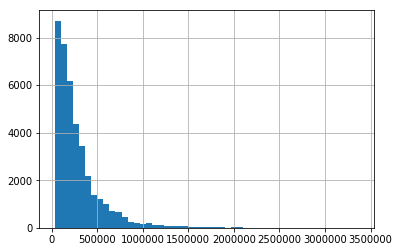

In [19]:
#de la visualización del histograma podemos ver que hay muchos outliers. Es normal porque hay zonas con viviendas con valores extremos
train['price'].hist(bins = 50)

Como vemos los precios están alineados a la izquierda. Para quitar el sesgo hacemos el logaritmo

### Como hemos visto antes los precios están alineados a la izquierda por lo que podemos decir que están sesgados. Vamos a transformarlo en logaritmicos para quitar el sesgo.


In [20]:
#reseteamos el índice
train.reset_index(drop=True, inplace=True)
train["price"] = np.log1p(train["price"])
y = train['price'].reset_index(drop=True)

C:\Users\Lor\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
#vamos a convertir también en logaritmico los precios de test para luego poder compararar con la predicción
test.reset_index(drop=True, inplace=True)
test["price"] = np.log1p(test["price"])
y_t = test['price'].reset_index(drop=True)

C:\Users\Lor\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Después de convertirlos en logaritmicos ahora podemos ver que nuestros precios están centrados, más balanceados

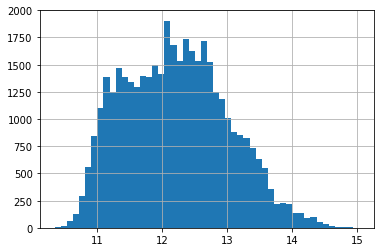

In [22]:
train['price'].hist(bins = 50)

## Vamos a ver la relación entre superficie y unitario

(0, 20000)

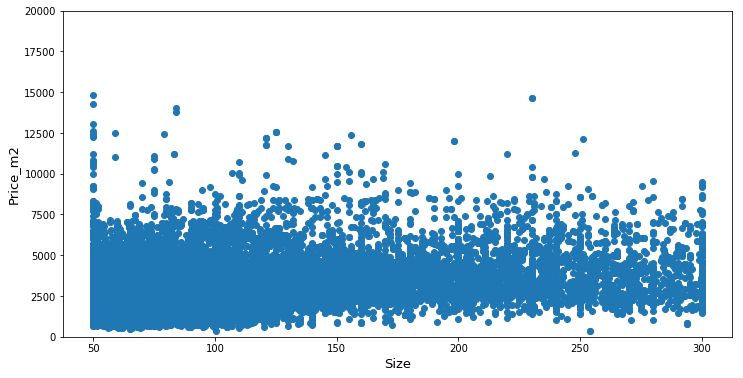

In [23]:
plt.figure(figsize=(12,6))
plt.scatter(x=train['size'], y=train['price_m2'])
plt.xlabel("Size", fontsize=13)
plt.ylabel("Price_m2", fontsize=13)
plt.ylim(0,20000)

## Vemos la correlacion entre variables

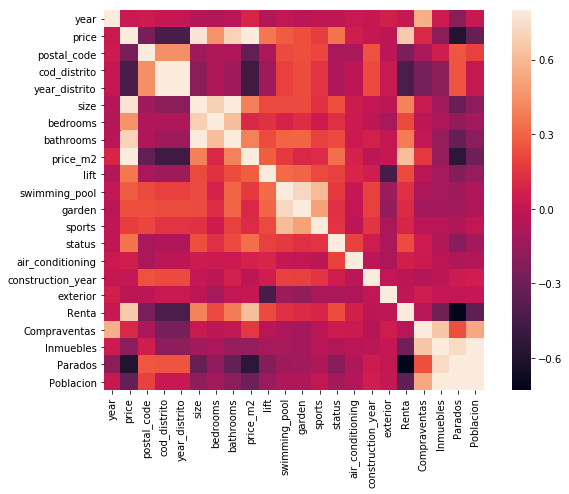

In [24]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(10,7))
sns.heatmap(corrmat, vmax=.8, square=True);

In [25]:
price_house_macro.corr()

,Unnamed: 0,year,price,postal_code,cod_distrito,year_distrito,size,bedrooms,bathrooms,price_m2,...,sports,status,air_conditioning,construction_year,exterior,Renta,Compraventas,Inmuebles,Parados,Poblacion
Unnamed: 0,1.000000,0.938014,0.114495,0.091622,0.038130,0.038157,-0.015325,-0.051520,0.011262,0.229613,...,0.011072,0.005927,0.102634,0.009189,0.080465,0.026142,0.464830,-0.068603,-0.262904,-0.040993
year,0.938014,1.000000,0.099924,0.093632,0.027633,0.027662,-0.029436,-0.061066,-0.004254,0.210484,...,0.008012,-0.004036,0.097963,0.009767,0.080074,0.018948,0.531355,-0.016442,-0.248192,0.000881
price,0.114495,0.099924,1.000000,-0.266565,-0.351092,-0.351089,0.805999,0.459375,0.678784,0.776751,...,0.124822,0.323827,0.115772,-0.020251,-0.006203,0.541123,0.142459,-0.109181,-0.438679,-0.217442
postal_code,0.091622,0.093632,-0.266565,1.000000,0.445661,0.445663,-0.124969,-0.085243,-0.064669,-0.325296,...,0.192473,-0.087839,-0.077965,0.171313,0.008614,-0.275786,-0.087826,0.029935,0.229205,0.170724
cod_distrito,0.038130,0.027633,-0.351092,0.445661,1.000000,1.000000,-0.175815,-0.064983,-0.109933,-0.475884,...,0.140619,-0.060455,-0.020280,0.151779,0.052998,-0.435638,-0.252539,-0.204773,0.234608,-0.001282
year_distrito,0.038157,0.027662,-0.351089,0.445663,1.000000,1.000000,-0.175815,-0.064985,-0.109933,-0.475877,...,0.140620,-0.060455,-0.020277,0.151780,0.053000,-0.435637,-0.252523,-0.204774,0.234600,-0.001282
size,-0.015325,-0.029436,0.805999,-0.124969,-0.175815,-0.175815,1.000000,0.697239,0.807212,0.370824,...,0.142601,0.247675,0.065922,0.010710,-0.017791,0.412723,0.027332,-0.110128,-0.316769,-0.171932
bedrooms,-0.051520,-0.061066,0.459375,-0.085243,-0.064983,-0.064985,0.697239,1.000000,0.633627,0.097377,...,0.051476,0.142766,0.040494,-0.007489,-0.089811,0.234412,-0.029381,-0.078777,-0.175347,-0.107417
bathrooms,0.011262,-0.004254,0.678784,-0.064669,-0.109933,-0.109933,0.807212,0.633627,1.000000,0.370476,...,0.191531,0.228253,0.062381,0.045514,-0.007555,0.383896,-0.010427,-0.150552,-0.328265,-0.193830
price_m2,0.229613,0.210484,0.776751,-0.325296,-0.475884,-0.475877,0.370824,0.097377,0.370476,1.000000,...,0.107018,0.325370,0.138779,-0.032859,-0.013422,0.618803,0.196544,-0.139206,-0.556042,-0.278128


Como habíamos observado en el modelo anterior, en el precio de la vivienda las variables intrínsecas que más influyen son size (0,81), bathrooms (0,68), bedrooms(0,46) y en menor medida status (0,27), lift(0,26) y swimming pool (0,1). El resto de variables no tienen relevancia e incluso algunas presentan correlaciones negativas. Muy destacable es que tanto el distrito como el código postal tienen una correlación negativa. Aun así vamos a mantener ambos ya que lo necesitaremos posteriormente para poder extraer el unitario por distrito, objetivo de este estudio.

De la observación de las variables macro que hemos introducido en el modelo, detectamos que sobre todo la Renta está muy correlacionada con el precio (0.54) y el número de compraventas en el distrito también tienen una correlación positiva, aunque no muy destacada (0,14). Por otro lado, vemos que tanto el número de inmuebles, el número de parados y la población no tienen correlación con el precio.

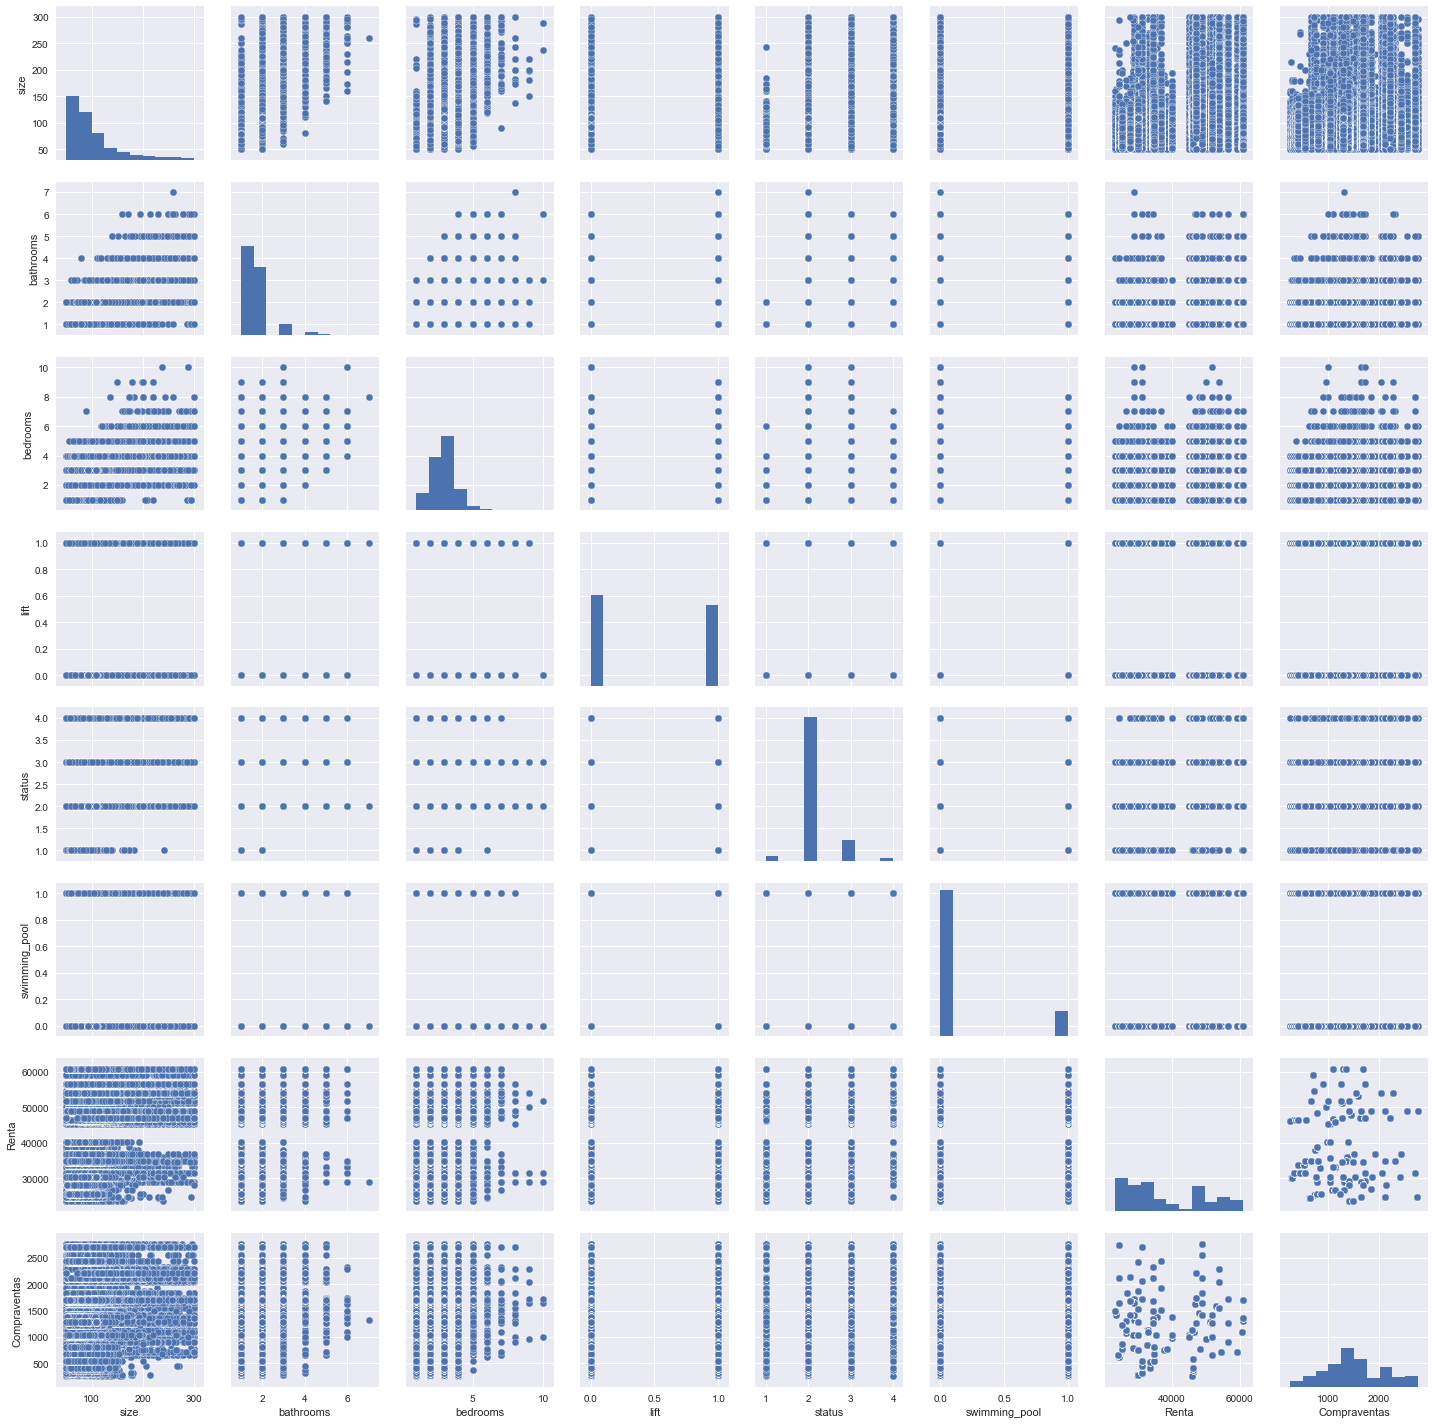

In [26]:
#scatterplot de las columnas más influyentes
sns.set()
cols = ['size', 'bathrooms', 'bedrooms', 'lift', 'status', 'swimming_pool', 'Renta','Compraventas' ]
sns.pairplot(train[cols], size = 2.5)
plt.show();

## Vamos a analizar ahora los outliers

#### Analizamos la superficie de las viviendas

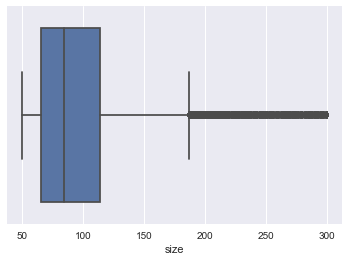

In [27]:
sns.boxplot(x=train['size'])

Con este boxplot vemos que por encima de aprox 175m² estaríamos hablando de outliers.
No obstante, no descartaremos estos valores porque consideramos que deben formar parte de los datos train ya que sí existen inmuebles de ese tipo.

#### Analizamos el unitario (€/m²) de las viviendas

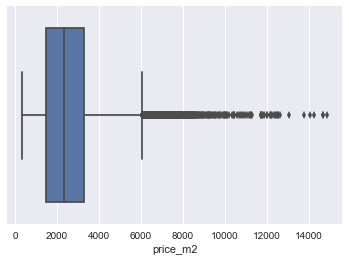

In [28]:
sns.boxplot(x=train['price_m2'])

Se observa que hay valores muy por encima de la "normalidad" (outliers) 
Más que de outliers aquí hablamos de errores porque en la extracción de los datos el volcado de la superficie es incorrecta.
Veremos más adelante como tratar esta información

#### Analizamos el precio de las viviendas

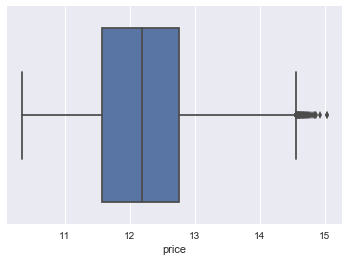

In [29]:
sns.boxplot(x=train['price'])

Después de la conversión en logaritmico vemos que existen outliers por encima del 14,5 aprox. Los eliminamos a continuación porque empeoran considerablemente la predicción.

In [30]:
#quitamos outliers

train_wout = train [(train['price'] < 14.00) & (train ['size'] < 175.00) & (train ['price_m2'] < 6000.00)]
test_wout = test [(test['price'] < 14.00) & (test ['size'] < 175.00) & (test ['price_m2'] < 6000.00)]

In [31]:
train_wout.shape

(35451, 23)

In [32]:
test_wout.shape

(15175, 23)

## Feature Selection 



In [33]:
train.columns

Index(['Fecha', 'year', 'price', 'postal_code', 'cod_distrito',
       'year_distrito', 'size', 'bedrooms', 'bathrooms', 'price_m2', 'lift',
       'swimming_pool', 'garden', 'sports', 'status', 'air_conditioning',
       'construction_year', 'exterior', 'Renta', 'Compraventas', 'Inmuebles',
       'Parados', 'Poblacion'],
      dtype='object')

### Seleccionamos las columnas que más aportan al modelo

In [34]:
X_train = train_wout[['size', 'bedrooms','bathrooms', 'lift', 'swimming_pool', 'garden', 'sports','status','air_conditioning', 'Renta','Compraventas']]
y_train = train_wout[['price']]

In [35]:
X_test = test[['size', 'bedrooms','bathrooms', 'lift', 'swimming_pool', 'garden', 'sports','status','air_conditioning', 'Renta','Compraventas']]
y_test = test[['price']]

## Desarrollando el modelo

### Validación cruzada

In [40]:
# Evaluamos métricas. CON RMSE
num_folds = 10
scoring = "r2"
# Score para cada algoritmo
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold,    scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(),   cv_results.std())
    print(msg)

LR: 0.717973 (0.100911)
LASSO: 0.651002 (0.121305)
EN: 0.654360 (0.119755)
KNN: 0.713302 (0.081745)
CART: 0.653118 (0.086837)


C:\Users\Lor\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lor\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lor\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lor\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed whe

RFR: 0.762368 (0.061605)


Los score del modelo anterior (donde no figuran las variables macro) eran las siguientes:
* LR: 0.530081 (0.177706)
* LASSO: 0.387310 (0.237306)
* EN: 0.388854 (0.239744)
* KNN: 0.503134 (0.214646)
* CART: 0.513710 (0.203325)
* RFR: 0.540647 (0.201568)

Si comparamos ambos resultados vemos que los score del actual modelo son mucho mejores. Vamos a ver ahora como afecta a nuestra predicción.

Vamos a volver a utilizar RandomForest que en nuestro modelo actual arroja un score de 0.76

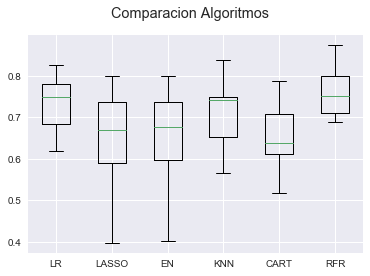

In [42]:
# Comparo los algoritmos
from matplotlib import pyplot

fig = pyplot.figure()
fig.suptitle('Comparacion Algoritmos')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [47]:
# Vamos a utilizar en el RF 1000 árboles
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Entreno el modelo con los datos de train que son anteriores a 2018
rf.fit(X_train, y_train);

C:\Users\Lor\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [48]:
# Ahora hacemos la predicción sobre el X_test que tiene menos datos porque es de 2018 a la actualidad
predictions = rf.predict(X_test)

In [49]:
#resultado de mi predicción con RandomForest
predictions

array([11.22925382, 11.1964033 , 11.43915851, ..., 11.32980103,
       11.22131664, 12.23860429])

In [50]:
#Convierto la predicción en un dataframe
prediccion=pd.DataFrame(predictions, columns=['prediccion'])
prediccion

,prediccion
0,11.229254
1,11.196403
2,11.439159
3,11.534280
4,11.074713
5,11.074713
6,11.074713
7,11.074713
8,11.074713
9,11.373928


In [51]:
prediccion.shape

(17246, 1)

In [53]:
unido =pd.concat([y_test, prediccion], axis =1, sort = True)
unido

,price,prediccion
0,11.251578,11.229254
1,11.112467,11.196403
2,11.502889,11.439159
3,11.418626,11.534280
4,11.501251,11.074713
5,11.511119,11.074713
6,11.505477,11.074713
7,11.518360,11.074713
8,11.529320,11.074713
9,11.468823,11.373928


# Aparentemente nuestro modelo ha mejorado

### Vamos a ver las métricas

In [54]:
mean_absolute_error(y_test, prediccion)


0.25848568172228037

In [56]:
mean_squared_error(y_test, prediccion)  


0.11868932254484074

In [59]:
np.sqrt(metrics.mean_squared_error(y_test, prediccion))

0.34451316744769095

#### Las métricas del modelo anterior (sin variables macro) eran las siguientes:

* mean_absolute_error: 0.35431368416513664
* mean_squared_error: 0.21993784549760054
* sqrt : 0.4689753143797662

#### Las actuales son:

* mean_absolute_error: 0.25848568172228037
* mean_squared_error: 0.11868932254484074
* sqrt : 0.34451316744769095

#### Podemos apreciar que las métricas han mejorado 

#### Ahora vamos a revertir el logaritmo


In [63]:
#revierto el log
y_prediccion = np.expm1(y_test)
back_prediccion = np.expm1(prediccion)

In [64]:
unido_sinlog =pd.concat([y_prediccion, back_prediccion], axis =1, sort = True)
unido_sinlog ['error'] = unido_sinlog['price']-unido_sinlog['prediccion']
unido_sinlog

,price,prediccion,error
0,77000.30,75300.385999,1699.914001
1,67000.30,72866.885728,-5866.585728
2,99000.36,92887.814121,6112.545879
3,91000.00,102157.414678,-11157.414678
4,98838.36,64517.868368,34320.491632
5,99818.55,64517.868368,35300.681632
6,99256.94,64517.868368,34739.071632
7,100543.97,64517.868368,36026.101632
8,101652.00,64517.868368,37134.131632
9,95684.60,87022.011063,8662.588937


In [65]:
unido_sinlog.describe()

,price,prediccion,error
count,1.724600e+04,17246.000000,1.724600e+04
mean,3.450175e+05,267034.607435,7.798292e+04
std,3.123056e+05,176706.631543,1.952865e+05
min,4.171074e+04,43347.894899,-3.581668e+05
25%,1.425000e+05,125904.858224,3.076074e+03
50%,2.460251e+05,213023.397690,3.191327e+04
75%,4.300000e+05,376436.086465,8.606104e+04
max,3.849998e+06,803348.945237,3.203828e+06


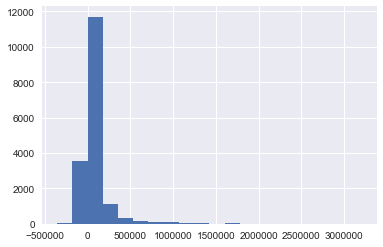

In [66]:
#distribución de mis errores en la predicción
unido_sinlog ['error'].hist(bins = 20)